In [1]:
from ib.ext.Contract import Contract
from ib.ext.ScannerSubscription import ScannerSubscription
from ib.ext.ContractDetails import ContractDetails
from ib.ext.Order import Order
from ib.opt import Connection, message

from time import sleep 
from datetime import datetime
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import re
from ibapi.ticktype import TickTypeEnum
import talib

In [2]:
from bs4 import BeautifulSoup
import requests
from pprint import pprint
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
r = requests.get('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
soup = BeautifulSoup(r.text,'html.parser')
T=[]
tickers = soup.find_all('a',{'class':'external text'},{'rel':'nofollow'})
for i in tickers[:-180]:
    if i.text == 'reports':
        del i
    else:
        T.append(i.text)
sp500 = T[:-11]

In [127]:
def demean(df):
    
    df_demean = pd.DataFrame()
    for date in df.index:
        for tick in df.columns:
            df_demean.loc[date,tick] = df.loc[date,tick] - df.loc[date,:].mean()
    return df_demean

def zscore(df):
    
    df_zscore = pd.DataFrame()
    for date in df.index:
        for tick in df.columns:
            df_zscore.loc[date,tick] = (df.loc[date,tick] - df.loc[date,:].mean())/df.loc[date,:].std(ddof=0)
    return df_zscore

In [4]:
def error_handler(msg):
    """Handles the capturing of error messages"""
    print ("Server Error: {}".format(msg))

def reply_handler(msg):
    """Handles of server replies"""
    print ("Server Response: {}, {}".format(msg.typeName, msg))

def next_id(msg):
    global order_id
    order_id = int(re.findall('\d+', str(msg))[0])
    
    return order_id
    
def historical_data_handler(msg):  
    global historical_data
    
    if ('finished' in str(msg.date)) == False:   
        
        historical_data.loc[len(historical_data)] = ([msg.date,
                                                      msg.open, msg.high, msg.low, msg.close, msg.volume])
    else:  
        historical_data.set_index('Date',inplace=True)

        
def ReportsFinStatements(msg):
    global annual
    global quarter
   
    parser = BeautifulSoup(msg.data, 'lxml')

    mapp = dict()
    for item in parser.findAll('mapitem'):
        mapp[item['coaitem']] = item.text
        
    
    #ANNUAL
    index = [];columns = []
    for item in parser.findAll('annualperiods')[0].findAll('fiscalperiod'):
        index.append(datetime.strptime(item['fiscalyear'], '%Y').year)
    
    for i in parser.findAll('annualperiods')[0].findAll('fiscalperiod')[0].findAll('lineitem'):
        columns.append(mapp[i['coacode']])

    annual = pd.DataFrame(index = index, columns = columns)
    annual.index.name = 'Annual'
    for item in parser.findAll('annualperiods')[0].findAll('fiscalperiod'):
        for i in item.findAll('lineitem'):
            try:
                annual.loc[datetime.strptime(item['fiscalyear'], '%Y').year,mapp[i['coacode']]] = float(i.text)
            except:
                annual.loc[datetime.strptime(item['fiscalyear'], '%Y').year,mapp[i['coacode']]] = np.nan
        
    # QUARTER
    index_q = [];columns_q = []
    for item in parser.findAll('interimperiods')[0].findAll('fiscalperiod'):
        index_q.append(datetime.strptime(item['enddate'], '%Y-%m-%d').date())
    
    for i in parser.findAll('interimperiods')[0].findAll('fiscalperiod')[0].findAll('lineitem'):
        columns_q.append(mapp[i['coacode']])

    quarter = pd.DataFrame(index = index_q, columns = columns_q)
    quarter.index.name = 'Quarter'
    for item in parser.findAll('interimperiods')[0].findAll('fiscalperiod'):
        for i in item.findAll('lineitem'):
            try:
                quarter.loc[datetime.strptime(item['enddate'], '%Y-%m-%d').date(),mapp[i['coacode']]] = float(i.text)
            except:
                quarter.loc[datetime.strptime(item['enddate'], '%Y-%m-%d').date(),mapp[i['coacode']]] = np.nan


def position_account(msg):
    global account
    account = msg

def Scanner(msg):
    global symbol
    global sectype
    global exchange
    global currency
        
    symbol.append(msg.contractDetails.m_summary.m_symbol)
    sectype.append(msg.contractDetails.m_summary.m_secType)
    exchange.append(msg.contractDetails.m_summary.m_exchange)
    currency.append(msg.contractDetails.m_summary.m_currency)

def Analyst_Estimates(msg):
    global resc
    global resc_ann
    global resc_q
    
    parser = BeautifulSoup(msg.data, 'lxml')
    resc.iloc[:,0] = parser.find('name').text    
    resc.iloc[:,1] = parser.find('exchange').text
    resc.iloc[:,2] = parser.findAll('secid')[0].text
    resc.iloc[:,3] = parser.findAll('sector')[0].text

    resc.iloc[:,4] = parser.findAll('marketdataitem')[0].text
    resc.iloc[:,5] = parser.findAll('marketdataitem')[1].text
    resc.iloc[:,6] = parser.findAll('marketdataitem')[2].text
    resc.iloc[:,7] = parser.findAll('marketdataitem')[3].text
    resc.iloc[:,8] = parser.findAll('marketdataitem')[4].text
    resc.iloc[:,9] = parser.findAll('fyactual')[0].text
    
    annual = [];columns = [];quarter = []
    for item in parser.findAll('fyactual'):
        columns.append(item['type'])
        for per in item.findAll('fyperiod'):
            if per['periodtype'] == 'A':
                annual.append(per['fyear'])
            if per['periodtype'] == 'Q':
                quarter.append('{}-{}'.format(per['endcalyear'],per['endmonth']))
    
    index = list(set(annual))
    index_q = list(set(quarter))
    resc_ann = pd.DataFrame(index = index, columns = columns).sort_index(axis = 0,ascending = False)
    resc_q = pd.DataFrame(index = index_q, columns = columns).sort_index(axis = 0,ascending = False)
    
    for item in parser.findAll('fyactual'):
        for per in item.findAll('fyperiod'):
            
            if per['periodtype'] == 'Q':
                try:
                    resc_q.loc['{}-{}'.format(per['endcalyear'],per['endmonth']),item['type']] = float(per.find('actvalue').text)
                except:
                    resc_q.loc['{}-{}'.format(per['endcalyear'],per['endmonth']),item['type']] = np.nan  
                    
            if per['periodtype'] == 'A':
                try:
                    resc_ann.loc[per['fyear'],item['type']] = float(per.find('actvalue').text)
                except:
                    resc_ann.loc[per['fyear'],item['type']] = np.nan

                    
def ReportsFinSummary(msg):
    global fin
    
    parser = BeautifulSoup(msg.data, 'lxml')
    date_div = [];data_div = []
    
    for i in parser.findAll('dividendpershare'):
        if i['period'] == '12M' and i['reporttype'] == 'TTM':
            
            date_div.append(i['asofdate'])
            try:
                data_div.append(float(i.text))
            except:
                data_div.append(np.nan)
                
    data_rev = []
    for i in parser.findAll('totalrevenue'):
        if i['period'] == '12M' and i['reporttype'] == 'TTM':
            try:
                data_rev.append(float(i.text))
            except:
                data_rev.append(np.nan)
                
    data_eps = []
    for i in parser.findAll('eps'):
        if i['period'] == '12M' and i['reporttype'] == 'TTM':
            try:
                data_eps.append(float(i.text))
            except:
                data_eps.append(np.nan)

    fin = pd.DataFrame(index = date_div,
                       data = {'Dividend Per Share(TTM)':data_div,
                               'Total Revenue(TTM)':data_rev, 
                               'EPS(TTM)':data_eps}).sort_index(axis = 0,ascending = False)

def ReportSnapshot(msg):
    global business_summary
    global brief
    global snap
    global address
    global ratio
    global estimate
    
    parser = BeautifulSoup(msg.data, 'lxml')
    
    business_summary = parser.findAll('text')[0].text
    brief = parser.findAll('text')[1].text
    address = '{},{},{},{}'.format(parser.find('contactinfo').find('streetaddress').text,
                                   parser.find('contactinfo').find('city').text,
                                   parser.find('contactinfo').find('state-region').text,
                                   parser.find('contactinfo').find('country').text)
    
    snap = pd.DataFrame(index = [parser.findAll('coid')[1].text],
                        data = {'Company Type': parser.find('cotype').text,
                                'Desc':parser.findAll('issue')[0]['desc'],
                                'Exchange': parser.findAll('exchange')[0].text,
                                'Industry':parser.findAll('industry')[0].text,
                                'Index':parser.find('indexconstituet').text})
    dicted = {};dicted_est = {}
    for i in range(len(parser.find('ratios').findAll('ratio'))):
        try:
            dicted[parser.find('ratios').findAll('ratio')[i]['fieldname']] = float(parser.find('ratios').findAll('ratio')[i].text)
        except:
            dicted[parser.find('ratios').findAll('ratio')[i]['fieldname']] = parser.find('ratios').findAll('ratio')[i].text
            
    ratio = pd.DataFrame(index = [parser.findAll('coid')[1].text], data = dicted)
    
    for i in range(len(parser.find('forecastdata').findAll('ratio'))):
        try:
            dicted_est[parser.find('forecastdata').findAll('ratio')[i]['fieldname']] = float(parser.find('forecastdata').findAll('ratio')[i].text)
        except:
            dicted_est[parser.find('forecastdata').findAll('ratio')[i]['fieldname']] = parser.find('forecastdata').findAll('ratio')[i].text
            
    estimate = pd.DataFrame(index = [parser.findAll('coid')[1].text], data = dicted_est)
    
def create_contract(symbol, sec_type, exch, prim_exch, curr):

    contract = Contract()
    contract.m_symbol = symbol
    contract.m_secType = sec_type
    contract.m_exchange = exch
    contract.m_primaryExch = prim_exch
    contract.m_currency = curr
    
    return contract

def create_order(order_type, quantity, action):

    order = Order()
    order.m_orderType = order_type
    order.m_totalQuantity = quantity
    order.m_action = action
    
    return order

def create_scanner(numberOfRows, instrument, locationCode, ScanCode, 
                   AbovePrice, marketCapAbove, AboveVolume):

    scanSub = ScannerSubscription()
    scanSub.numberOfRows(numberOfRows)
    scanSub.m_instrument = instrument
    scanSub.m_locationCode = locationCode
    scanSub.m_scanCode = ScanCode
    scanSub.m_abovePrice = AbovePrice
    scanSub.m_marketCapAbove = marketCapAbove
    scanSub.m_aboveVolume = AboveVolume
    
    return scanSub



In [5]:
#price = pd.DataFrame(columns = ['Ticker Id','Field','Price'])
#size = pd.DataFrame()
#scan_param = None
#tws_conn.register(ScannerParameters, message.scannerParameters)
#tws_conn.register(mktdata, message.tickPrice)
#tws_conn.reqMarketDataType(4) # switch to delayed frozen data if live is not available
#tws_conn.reqMktData(0,contract,"",True)                    
#tws_conn.reqScannerParameters()

# Connecting to TWS

In [6]:
tws_conn = Connection.create(host='127.0.0.1',port=7497, clientId=0)
tws_conn.connect()

Server Version: 76
TWS Time at connection:20191017 06:25:26 EST


True

In [7]:
tws_conn.register(error_handler, 'Error')
tws_conn.register(reply_handler)
#tws_conn.unregister(error_handler, 'Error')
#tws_conn.unregister(reply_handler)

False

In [8]:
contracts = []
for stock in sp500:
    try:
        contract = create_contract(symbol = stock,
                                   sec_type = 'STK',
                                    exch = 'SMART',
                                   prim_exch = 'NASDAQ',
                                    curr = 'USD')
        contracts.append(contract)
    except:
        continue

In [9]:
contracts

## RESC: Analyst estimates

In [10]:
sector = []
for i,contract in enumerate(contracts[:40]):
    
    resc = pd.DataFrame(index = [0],columns = ['Name', 'Exchange', 'Symbol', 'Sector', 'CLPRICE', 'SHARESOUT',
                                          'MARKETCAP', '52WKHIGH', '52WKLOW','NAV'])

    resc_ann = pd.DataFrame()
    resc_q = pd.DataFrame()

    tws_conn.register(Analyst_Estimates, message.fundamentalData)
    tws_conn.reqFundamentalData(i,contract=contract,reportType='RESC')
    sleep(5)
    tws_conn.unregister(Analyst_Estimates, message.fundamentalData)
    try:
        sector.append(resc['Sector'].values)
    except:
        sector.append(np.nan)

Server Error: <error id=26, errorCode=430, errorMsg=We are sorry, but fundamentals data for the security specified is not available.failed to fetch>


In [12]:
len(sector)

40

## Technical Data

In [13]:
historical_data = pd.DataFrame(columns=['Date', 'Open', 'High', 'Low', 'Close', 'Volume'])

In [14]:
tws_conn.register(historical_data_handler, message.historicalData)
tws_conn.reqHistoricalData(0, contracts[0],'','2 Y','1 day','TRADES',1,1)
sleep(5)
tws_conn.unregister(historical_data_handler, message.historicalData)

True

In [15]:
historical_data['RSI'] = talib.RSI(historical_data['Close'], timeperiod=7)
historical_data['5d-Return'] = (historical_data['Close'] - historical_data['Close'].shift(5))/historical_data['Close']
historical_data['macd'], historical_data['macdsignal'], historical_data['macdhist'] = talib.MACDEXT(historical_data['Close'], fastperiod=12, fastmatype=1, slowperiod=26, slowmatype=1, signalperiod=9, signalmatype=1)
historical_data['Beta'] = talib.BETA(historical_data['High'],historical_data['Low'], timeperiod=5)
# arrays = [[[contract.m_symbol]*len(historical_data.index)][0], list(historical_data.index)]
# tuples = list(zip(*arrays))
# index = pd.MultiIndex.from_tuples(tuples, names=['Symbol', 'Date'])
#historical_data = pd.DataFrame(index = index, data = historical_data.values, columns = historical_data.columns)

In [16]:
historical_data.tail(10)

Open    High     Low   Close Volume        RSI  5d-Return  \
Date                                                                    
20191003  155.14  155.46  150.81  155.23  18829  13.876082  -0.055402   
20191004  155.23  156.05  154.40  155.82  18149  18.968420  -0.055898   
20191007  155.00  155.35  153.52  153.52  16930  14.948527  -0.070870   
20191008  152.33  152.80  150.58  150.74  19113  11.509086  -0.050683   
20191009  152.34  152.44  150.79  150.99  22714  13.594878  -0.030863   
20191010  150.95  153.10  150.87  152.31  23670  24.549891  -0.019171   
20191011  154.13  159.60  154.11  158.10  32261  54.239961   0.014421   
20191014  158.04  162.39  157.34  160.51  25228  61.581357   0.043549   
20191015  159.35  164.02  159.35  162.98  19875  67.765026   0.075101   
20191016  163.10  164.20  162.12  162.18  12612  63.879874   0.068997   

              macd  macdsignal  macdhist      Beta  
Date                                                
20191003 -1.682063   -0.375744 -1.306319  0.334258  
20191004 -2.033130   -0.707221 -1.325909  0.483903  
20191007 -2.468488   -1.059475 -1.409014  0.435094  
20191008 -3.003217   -1.448223 -1.554994  0.660002  
20191009 -3.367996   -1.832178 -1.535818  2.244846  
20191010 -3.510110   -2.167764 -1.342346  1.529149  
20191011 -3.119572   -2.358126 -0.761446  0.626987  
20191014 -2.585794   -2.403659 -0.182134  0.685225  
20191015 -1.941086   -2.311145  0.370059  0.486914  
20191016 -1.477671   -2.144450  0.666779  0.297725

In [17]:
price = pd.DataFrame(index = historical_data.index,data = [], columns = sp500)

In [18]:
for i,tick in enumerate(sp500[:40]):
    historical_data = pd.DataFrame(columns=['Date', 'Open', 'High', 'Low', 'Close', 'Volume'])
    resc = pd.DataFrame(index = [0],columns = ['Name', 'Exchange', 'Symbol', 'Sector', 'CLPRICE', 'SHARESOUT',
                                              'MARKETCAP', '52WKHIGH', '52WKLOW','NAV'])    
    
    resc_ann = pd.DataFrame();resc_q = pd.DataFrame()
    
    tws_conn.register(Analyst_Estimates, message.fundamentalData)
    tws_conn.register(historical_data_handler, message.historicalData)
    
    tws_conn.reqFundamentalData(i,contract=contract,reportType='RESC')    
    tws_conn.reqHistoricalData(i, contracts[i],'','2 Y','1 day','TRADES',1,1)
    sleep(5)
    price[tick] = historical_data['Close']
    tws_conn.unregister(historical_data_handler, message.historicalData)
    tws_conn.unregister(Analyst_Estimates, message.fundamentalData)
    
    try:
        sector.append(resc['Sector'].values)
    except:
        sector.append(np.nan)

In [19]:
price = price.iloc[:,:40]

In [43]:
returns_5days  = price.apply(lambda x:(x - x.shift(5))/x).iloc[1:,:].fillna(0).iloc[5:,:]

In [44]:
returns_5days .head()

MMM       ABT      ABBV      ABMD       ACN      ATVI  \
Date                                                                   
20171025  0.081664 -0.005046 -0.046529 -0.009220  0.026495  0.005015   
20171026  0.058813 -0.009373 -0.077267  0.041094  0.023597  0.001128   
20171027  0.057170 -0.017157 -0.045361  0.035622  0.026452  0.023542   
20171030  0.040992 -0.032971 -0.039028  0.019389  0.027636  0.058806   
20171031 -0.019375 -0.021206 -0.015956  0.084024  0.024234  0.042144   

              ADBE       AMD       AAP       AES    ...          AEE  \
Date                                                ...                
20171025  0.109585 -0.141119 -0.054015 -0.021101    ...     0.001473   
20171026  0.011626 -0.162016 -0.014828 -0.039595    ...    -0.002933   
20171027  0.009530 -0.166385 -0.059197 -0.032468    ...     0.003883   
20171030  0.021985 -0.294766 -0.047683 -0.036313    ...     0.001779   
20171031  0.020438 -0.297223 -0.030707 -0.033866    ...     0.004194   

               AAL       AEP       AXP       AIG       AMT       AWK  \
Date                                                                   
20171025 -0.019796  0.007747  0.015503  0.025499 -0.001092  0.008167   
20171026 -0.059659 -0.000949  0.039607 -0.003392  0.000433  0.002857   
20171027 -0.091884  0.000540  0.038626 -0.004957 -0.000288 -0.001027   
20171030 -0.078942  0.003371  0.028295 -0.002779  0.028837  0.000342   
20171031 -0.109569  0.005913  0.017379 -0.008048  0.039257  0.010711   

               AMP       ABC       AME  
Date                                    
20171025  0.027505  0.021041  0.008612  
20171026  0.063575 -0.043544  0.011989  
20171027  0.040468 -0.089421  0.008816  
20171030  0.026027 -0.072793 -0.012716  
20171031  0.016418 -0.063678 -0.018373  

[5 rows x 40 columns]

# Statistical Risk Model
It's time to build the risk model. You'll be creating a statistical risk model using PCA. So, the first thing is building the PCA model.
## Fit PCA
Implement `fit_pca` to fit a PCA model to the returns data

In [45]:
from sklearn.decomposition import PCA


def fit_pca(returns, num_factor_exposures, svd_solver):
    """
    Fit PCA model with returns.

    Parameters
    ----------
    returns : DataFrame
        Returns for each ticker and date
    num_factor_exposures : int
        Number of factors for PCA
    svd_solver: str
        The solver to use for the PCA model

    Returns
    -------
    pca : PCA
        Model fit to returns
    """
    pca = PCA(n_components=num_factor_exposures, svd_solver=svd_solver)
    pca.fit(returns)
    
    return pca

In [46]:
num_factor_exposures = 10
pca = fit_pca(returns_5days, num_factor_exposures, 'full')

pca.components_.shape

(10, 40)

17-Oct-19 06:37:13 DEBUG     update_title_pos
17-Oct-19 06:37:13 DEBUG     update_title_pos
17-Oct-19 06:37:13 DEBUG     update_title_pos
17-Oct-19 06:37:13 DEBUG     update_title_pos
17-Oct-19 06:37:13 DEBUG     update_title_pos


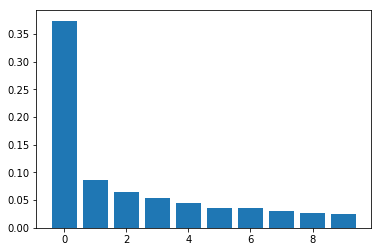

In [47]:
plt.bar(np.arange(num_factor_exposures), pca.explained_variance_ratio_);

## Factor Betas
Implement `factor_betas` to get the factor betas from the PCA model.

In [48]:
def factor_betas(pca, factor_beta_indices, factor_beta_columns):
    """
    Get the factor betas from the PCA model.

    Parameters
    ----------
    pca : PCA
        Model fit to returns
    factor_beta_indices : 1 dimensional Ndarray
        Factor beta indices
    factor_beta_columns : 1 dimensional Ndarray
        Factor beta columns

    Returns
    -------
    factor_betas : DataFrame
        Factor betas
    """
    assert len(factor_beta_indices.shape) == 1
    assert len(factor_beta_columns.shape) == 1
    
    factor_betas = pd.DataFrame(pca.components_.T, factor_beta_indices, factor_beta_columns)
    return factor_betas

In [49]:
risk_model = {}
risk_model['factor_betas'] = factor_betas(pca, returns_5days.columns.values, np.arange(num_factor_exposures))

risk_model['factor_betas']

0         1         2         3         4         5         6  \
MMM   -0.144770  0.134622  0.063301 -0.044085 -0.019613 -0.138743  0.020313   
ABT   -0.124484  0.009400  0.049646 -0.041058  0.068669 -0.056876 -0.014643   
ABBV  -0.139333  0.015636 -0.029041 -0.148049  0.159255 -0.031288  0.008111   
ABMD  -0.300228 -0.414562  0.524552  0.268705 -0.028138 -0.073886 -0.540876   
ACN   -0.122804  0.057770  0.050140 -0.096824  0.087120 -0.104962  0.035968   
ATVI  -0.162963 -0.160231  0.228007  0.135363  0.117615  0.140061  0.578661   
ADBE  -0.164530 -0.087319  0.118695 -0.084651  0.047989 -0.069774  0.115061   
AMD   -0.403225 -0.204622 -0.639432  0.479455  0.280284 -0.153926  0.002760   
AAP   -0.105005  0.126261 -0.045047 -0.087639  0.010305  0.197135 -0.178740   
AES   -0.079339  0.056372  0.000193 -0.147864  0.125193 -0.051893 -0.148590   
AMG   -0.172068  0.213545  0.087458  0.062827 -0.097725  0.115065 -0.036805   
AFL   -0.083537  0.066130 -0.051670 -0.087645 -0.021070 -0.049105 -0.060336   
A     -0.154209  0.053678  0.119638 -0.043511  0.053278 -0.029984  0.067896   
APD   -0.092844  0.070211  0.011257 -0.057521  0.023315 -0.133997  0.025417   
AKAM  -0.134733  0.058224  0.118363 -0.023637  0.033177 -0.062315  0.188727   
ALK   -0.123733  0.297932 -0.155585  0.147810 -0.156864  0.074528 -0.018598   
ALB   -0.175088  0.192724  0.073621  0.123127 -0.065309 -0.315778 -0.057686   
ARE   -0.051818  0.037752 -0.002896 -0.151581  0.127722 -0.124120 -0.026599   
ALXN  -0.214459  0.069939  0.032566 -0.047230  0.159508  0.426390 -0.093819   
ALGN  -0.338793 -0.472574 -0.271435 -0.470973 -0.530145  0.098847  0.048023   
ALLE  -0.126289  0.133364  0.019279 -0.059871 -0.060388 -0.040530 -0.002953   
AGN   -0.136143  0.047690 -0.014239 -0.103804  0.259500  0.592266 -0.047020   
ADS   -0.166844  0.199957  0.027820  0.067869  0.055639  0.109012 -0.078263   
LNT   -0.005232  0.037299 -0.081790 -0.200039  0.146678 -0.095162 -0.120613   
ALL   -0.070761  0.105635  0.022495 -0.117213 -0.032326 -0.047191 -0.022866   
GOOGL -0.151979 -0.006717  0.136908 -0.076669  0.150959 -0.088188  0.249297   
GOOG  -0.153018 -0.002907  0.134657 -0.076570  0.147493 -0.088983  0.250094   
MO    -0.056856  0.079876  0.072824 -0.119924  0.089767 -0.090033 -0.061184   
AMZN  -0.195582 -0.130903  0.096008 -0.073319  0.066129 -0.023167  0.111605   
AMCR  -0.015151  0.016897  0.017044  0.034555 -0.029061  0.037494 -0.037660   
AEE   -0.003001  0.027579 -0.087151 -0.198460  0.133267 -0.134499 -0.158834   
AAL   -0.204121  0.324598  0.012305  0.108866 -0.469036 -0.048655  0.112051   
AEP   -0.000468  0.033593 -0.072468 -0.196640  0.110487 -0.109917 -0.121305   
AXP   -0.116162  0.107989  0.031747 -0.082946  0.046263 -0.119778 -0.017902   
AIG   -0.123660  0.084809 -0.083800  0.065551 -0.053541  0.041750 -0.058460   
AMT   -0.010894 -0.001533 -0.032840 -0.202142  0.160878 -0.190359  0.038408   
AWK   -0.008544  0.022440 -0.083392 -0.219277  0.174333 -0.115951 -0.090181   
AMP   -0.197185  0.184640  0.053937 -0.009261 -0.116915 -0.002187 -0.052362   
ABC   -0.151018  0.172194 -0.035053 -0.103547  0.071493  0.119119 -0.086893   
AME   -0.144539  0.092349  0.038285 -0.017257 -0.006337 -0.076469  0.011041   

              7         8         9  
MMM   -0.113551  0.152733  0.170299  
ABT    0.064671  0.003346 -0.016367  
ABBV   0.343490  0.602937 -0.193551  
ABMD   0.138199 -0.068523  0.076324  
ACN   -0.009323 -0.060397  0.010106  
ATVI  -0.039871 -0.097879 -0.084059  
ADBE   0.076632 -0.190642  0.073514  
AMD    0.016438 -0.057588  0.079982  
AAP    0.286708  0.093252  0.078855  
AES    0.033847 -0.098945  0.144549  
AMG   -0.111751  0.170468  0.274156  
AFL   -0.030907  0.111843  0.078143  
A     -0.087527 -0.015634 -0.025898  
APD   -0.099649  0.088276  0.063869  
AKAM   0.168635 -0.233792 -0.079712  
ALK    0.282175 -0.215755 -0.012428  
ALB   -0.537134  0.041163 -0.422155  
ARE    0.085524 -0.103455 -0.023697  
ALXN   0.052588 -0.060386 -0.528388  
ALGN  -0.12758

## Factor Returns
Implement `factor_returns` to get the factor returns from the PCA model using the returns data.

In [50]:
def factor_returns(pca, returns, factor_return_indices, factor_return_columns):
    """
    Get the factor returns from the PCA model.

    Parameters
    ----------
    pca : PCA
        Model fit to returns
    returns : DataFrame
        Returns for each ticker and date
    factor_return_indices : 1 dimensional Ndarray
        Factor return indices
    factor_return_columns : 1 dimensional Ndarray
        Factor return columns

    Returns
    -------
    factor_returns : DataFrame
        Factor returns
    """
    assert len(factor_return_indices.shape) == 1
    assert len(factor_return_columns.shape) == 1
    
    factor_returns =pd.DataFrame(pca.transform(returns_5days), factor_return_indices, factor_return_columns)
    return factor_returns

17-Oct-19 06:37:17 DEBUG     update_title_pos
17-Oct-19 06:37:17 DEBUG     update_title_pos
17-Oct-19 06:37:17 DEBUG     update_title_pos
17-Oct-19 06:37:17 DEBUG     update_title_pos
17-Oct-19 06:37:17 DEBUG     update_title_pos


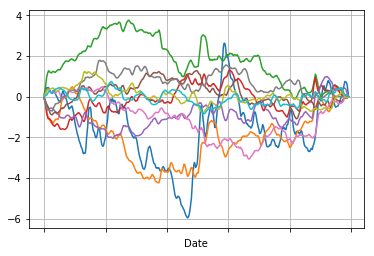

In [51]:
risk_model['factor_returns'] = factor_returns(
    pca,
    returns_5days,
    returns_5days.index,
    np.arange(num_factor_exposures))

risk_model['factor_returns'].cumsum().plot(legend=None,grid=True)

## Factor Covariance Matrix
Implement `factor_cov_matrix` to get the factor covariance matrix.

In [52]:
def factor_cov_matrix(factor_returns, ann_factor):
    """
    Get the factor covariance matrix

    Parameters
    ----------
    factor_returns : DataFrame
        Factor returns
    ann_factor : int
        Annualization factor

    Returns
    -------
    factor_cov_matrix : 2 dimensional Ndarray
        Factor covariance matrix
    """
    annualized_factor_covariance_matrix = np.diag(factor_returns.var(axis=0, ddof=1)*ann_factor)
    
    return annualized_factor_covariance_matrix

In [53]:
ann_factor = 252
risk_model['factor_cov_matrix'] = factor_cov_matrix(risk_model['factor_returns'], ann_factor)

risk_model['factor_cov_matrix']

array([[6.42899724, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 1.49620838, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 1.11421067, 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.93025773, 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.76949593,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.62589045, 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.60650951, 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.       

## Idiosyncratic Variance Matrix
Implement `idiosyncratic_var_matrix` to get the idiosyncratic variance matrix.

In [54]:
def idiosyncratic_var_matrix(returns, factor_returns, factor_betas, ann_factor):
    """
    Get the idiosyncratic variance matrix

    Parameters
    ----------
    returns : DataFrame
        Returns for each ticker and date
    factor_returns : DataFrame
        Factor returns
    factor_betas : DataFrame
        Factor betas
    ann_factor : int
        Annualization factor

    Returns
    -------
    idiosyncratic_var_matrix : DataFrame
        Idiosyncratic variance matrix
    """
    
    common_returns_ = pd.DataFrame(np.dot(factor_returns, factor_betas.T), returns.index, returns.columns)
    
    residuals_ = (returns - common_returns_)
    specific_risk_matrix = pd.DataFrame(np.diag(np.var(residuals_))*ann_factor, returns.columns, returns.columns)
    return specific_risk_matrix

In [55]:
risk_model['idiosyncratic_var_matrix'] = idiosyncratic_var_matrix(returns_5days, risk_model['factor_returns'], risk_model['factor_betas'], ann_factor)

risk_model['idiosyncratic_var_matrix']

MMM       ABT     ABBV      ABMD       ACN     ATVI      ADBE  \
MMM    0.123153  0.000000  0.00000  0.000000  0.000000  0.00000  0.000000   
ABT    0.000000  0.079555  0.00000  0.000000  0.000000  0.00000  0.000000   
ABBV   0.000000  0.000000  0.08464  0.000000  0.000000  0.00000  0.000000   
ABMD   0.000000  0.000000  0.00000  0.012321  0.000000  0.00000  0.000000   
ACN    0.000000  0.000000  0.00000  0.000000  0.057792  0.00000  0.000000   
ATVI   0.000000  0.000000  0.00000  0.000000  0.000000  0.13906  0.000000   
ADBE   0.000000  0.000000  0.00000  0.000000  0.000000  0.00000  0.093336   
AMD    0.000000  0.000000  0.00000  0.000000  0.000000  0.00000  0.000000   
AAP    0.000000  0.000000  0.00000  0.000000  0.000000  0.00000  0.000000   
AES    0.000000  0.000000  0.00000  0.000000  0.000000  0.00000  0.000000   
AMG    0.000000  0.000000  0.00000  0.000000  0.000000  0.00000  0.000000   
AFL    0.000000  0.000000  0.00000  0.000000  0.000000  0.00000  0.000000   
A      0.000000  0.000000  0.00000  0.000000  0.000000  0.00000  0.000000   
APD    0.000000  0.000000  0.00000  0.000000  0.000000  0.00000  0.000000   
AKAM   0.000000  0.000000  0.00000  0.000000  0.000000  0.00000  0.000000   
ALK    0.000000  0.000000  0.00000  0.000000  0.000000  0.00000  0.000000   
ALB    0.000000  0.000000  0.00000  0.000000  0.000000  0.00000  0.000000   
ARE    0.000000  0.000000  0.00000  0.000000  0.000000  0.00000  0.000000   
ALXN   0.000000  0.000000  0.00000  0.000000  0.000000  0.00000  0.000000   
ALGN   0.000000  0.000000  0.00000  0.000000  0.000000  0.00000  0.000000   
ALLE   0.000000  0.000000  0.00000  0.000000  0.000000  0.00000  0.000000   
AGN    0.000000  0.000000  0.00000  0.000000  0.000000  0.00000  0.000000   
ADS    0.000000  0.000000  0.00000  0.000000  0.000000  0.00000  0.000000   
LNT    0.000000  0.000000  0.00000  0.000000  0.000000  0.00000  0.000000   
ALL    0.000000  0.000000  0.00000  0.000000  0.000000  0.00000  0.000000   
GOOGL  0.000000  0.000000  0.00000  0.000000  0.000000  0.00000  0.000000   
GOOG   0.000000  0.000000  0.00000  0.000000  0.000000  0.00000  0.000000   
MO     0.000000  0.000000  0.00000  0.000000  0.000000  0.00000  0.000000   
AMZN   0.000000  0.000000  0.00000  0.000000  0.000000  0.00000  0.000000   
AMCR   0.000000  0.000000  0.00000  0.000000  0.000000  0.00000  0.000000   
AEE    0.000000  0.000000  0.00000  0.000000  0.000000  0.00000  0.000000   
AAL    0.000000  0.000000  0.00000  0.000000  0.000000  0.00000  0.000000   
AEP    0.000000  0.000000  0.00000  0.000000  0.000000  0.00000  0.000000   
AXP    0.000000  0.000000  0.00000  0.000000  0.000000  0.00000  0.000000   
AIG    0.000000  0.000000  0.00000  0.000000  0.000000  0.00000  0.000000   
AMT    0.000000  0.000000  0.00000  0.000000  0.000000  0.00000  0.000000   
AWK    0.000000  0.000000  0.00000  0.000000  0.000000  0.00000  0.000000   
AMP    0.000000  0.000000  0.00000  0.000000  0.000000  0.00000  0.000000   
ABC    0.000000  0.000000  0.00000  0.000000  0.000000  0.00000  0.000000   
AME    0.000000  0.000000  0.00000  0.000000  0.000000  0.00000  0.000000   

            AMD       AAP      AES    ...          AEE      AAL       AEP  \
MMM    0.000000  0.000000  0.00000    ...     0.000000  0.00000  0.000000   
ABT    0.000000  0.000000  0.00000    ...     0.000000  0.00000  0.000000   
ABBV   0.000000  0.000000  0.00000    ...     0.000000  0.00000  0.000000   
ABMD   0.000000  0.000000  0.00000    ...     0.000000  0.00000  0.000000   
ACN    0.000000  0.000000  0.00000    ...     0.000000  0.00000  0.000000   
ATVI   0.000000  0.000000  0.00000    ...     0.000000  0.00000  0.000000   
ADBE   0.000000  0.000000  0.00000    ...     0.000000  0.00000  0.000000   
AMD    0.009297  0.000000  0.00000    ...     0.000000  0.00000  0.000000   
AAP    0.000000  0.215798  0.00000    ...     0.000000  0.00000  0.000000   
AES    0.000000  0.000000  0.14755    ...     0.000000  0.00000  0.000000   
AMG    

## Idiosyncratic Variance Vector
Implement `idiosyncratic_var_vector` to get the idiosyncratic variance Vector.

In [56]:
def idiosyncratic_var_vector(returns, idiosyncratic_var_matrix):
    """
    Get the idiosyncratic variance vector

    Parameters
    ----------
    returns : DataFrame
        Returns for each ticker and date
    idiosyncratic_var_matrix : DataFrame
        Idiosyncratic variance matrix

    Returns
    -------
    idiosyncratic_var_vector : DataFrame
        Idiosyncratic variance Vector
    """

    idiosyncratic_var_vector = pd.DataFrame(np.diag(idiosyncratic_var_matrix),index=returns.columns)   
    return idiosyncratic_var_vector

In [57]:
risk_model['idiosyncratic_var_vector'] = idiosyncratic_var_vector(returns_5days, risk_model['idiosyncratic_var_matrix'])

risk_model['idiosyncratic_var_vector']

0
MMM    0.123153
ABT    0.079555
ABBV   0.084640
ABMD   0.012321
ACN    0.057792
ATVI   0.139060
ADBE   0.093336
AMD    0.009297
AAP    0.215798
AES    0.147550
AMG    0.131179
AFL    0.066754
A      0.149402
APD    0.077634
AKAM   0.161744
ALK    0.129551
ALB    0.083118
ARE    0.066552
ALXN   0.129385
ALGN   0.008396
ALLE   0.104502
AGN    0.065440
ADS    0.187436
LNT    0.027597
ALL    0.076983
GOOGL  0.064078
GOOG   0.063840
MO     0.231849
AMZN   0.153291
AMCR   0.037529
AEE    0.035204
AAL    0.078480
AEP    0.032615
AXP    0.076394
AIG    0.143894
AMT    0.084528
AWK    0.037135
AMP    0.091402
ABC    0.185473
AME    0.056836

## Predict using the Risk Model
Using the data we calculated in the risk model, implement `predict_portfolio_risk` to predict the portfolio risk using the formula $ \sqrt{X^{T}(BFB^{T} + S)X} $ where:
- $ X $ is the portfolio weights
- $ B $ is the factor betas
- $ F $ is the factor covariance matrix
- $ S $ is the idiosyncratic variance matrix

In [58]:
def predict_portfolio_risk(factor_betas, factor_cov_matrix, idiosyncratic_var_matrix, weights):
    """
    Get the predicted portfolio risk
    
    Formula for predicted portfolio risk is sqrt(X.T(BFB.T + S)X) where:
      X is the portfolio weights
      B is the factor betas
      F is the factor covariance matrix
      S is the idiosyncratic variance matrix

    Parameters
    ----------
    factor_betas : DataFrame
        Factor betas
    factor_cov_matrix : 2 dimensional Ndarray
        Factor covariance matrix
    idiosyncratic_var_matrix : DataFrame
        Idiosyncratic variance matrix
    weights : DataFrame
        Portfolio weights

    Returns
    -------
    predicted_portfolio_risk : float
        Predicted portfolio risk
    """
    assert len(factor_cov_matrix.shape) == 2
    
    K = factor_betas.dot(factor_cov_matrix).dot(factor_betas.T) + idiosyncratic_var_matrix
    
    predicted_portfolio_risk = np.sqrt(weights.T.dot(K).dot(weights))    
    
    return predicted_portfolio_risk.values[0][0]

In [59]:
all_weights = pd.DataFrame(np.repeat(1/len(returns_5days.columns), len(returns_5days.columns)), returns_5days.columns)

predict_portfolio_risk(
    risk_model['factor_betas'],
    risk_model['factor_cov_matrix'],
    risk_model['idiosyncratic_var_matrix'],
    all_weights)

0.3495013386925824

# Create Alpha Factors
With the profile risk calculated, it's time to start working on the alpha factors. In this project, we'll create the following factors:
- Momentum 1 Year Factor
- Mean Reversion 5 Day Sector Neutral Factor
- Mean Reversion 5 Day Sector Neutral Smoothed Factor
- Overnight Sentiment Factor
- Overnight Sentiment Smoothed Factor

## Momentum 5day Factor
Each factor will have a hypothesis that goes with it. For this factor, it is "Higher past 12-month (252 days) returns are proportional to future return." Using that hypothesis, we've generated this code:

In [138]:
returns_5days_demean_ranked = demean(returns_5days).rank(axis=1)

In [147]:
returns_5days_demean_zscore = zscore(returns_5days_demean_ranked)

In [144]:
returns_5days_demean_ranked.loc['20171025',:][returns_5days_demean_ranked.loc['20171025',:]==returns_5days_demean_ranked.loc['20171025',:].max()]

ADBE    40.0
Name: 20171025, dtype: float64

In [146]:
returns_5days.loc['20171025',:][returns_5days.loc['20171025',:]==returns_5days.loc['20171025',:].max()]

ADBE    0.109585
Name: 20171025, dtype: float64

In [148]:
returns_5days_demean_zscore.loc['20171025',:][returns_5days_demean_zscore.loc['20171025',:]==returns_5days_demean_zscore.loc['20171025',:].max()]

ADBE    1.689278
Name: 20171025, dtype: float64

## Mean Reversion 5 Day Sector Neutral Factor
Now it's time for you to implement `mean_reversion_5day_sector_neutral` using the hypothesis "Short-term outperformers(underperformers) compared to their sector will revert." Use the returns data from `universe`, demean using the sector data to partition, rank, then converted to a zscore.

In [61]:
def mean_reversion_5day_sector_neutral(window_length, universe, sector):
    """
    Generate the mean reversion 5 day sector neutral factor

    Parameters
    ----------
    window_length : int
        Returns window length
    universe : Zipline Filter
        Universe of stocks filter
    sector : Zipline Classifier
        Sector classifier

    Returns
    -------
    factor : Zipline Factor
        Mean reversion 5 day sector neutral factor
    """

    factor = momentum_1yr(window_length=window_length, 
                          universe=universe, 
                          sector=sector)*-1
    
    return factor

In [98]:
df = returns_5days.stack().to_frame('Returns5d')
df.index.levels[1].name = 'Symbol'

In [99]:
d = {}
for sec,tick in zip(sector, returns_5days.columns):
    d[tick]=sec[0]
    
for date in df.index.levels[0]:
    for tick in df.index.levels[1]:
        df.loc[(date,tick),'Sector'] = d[tick]

In [111]:
df['Returns5d_demean'] = df['Returns5d'].sub(df['Returns5d'].mean())

In [150]:
df

Returns5d                                  Sector  \
Date     Symbol                                                      
20171025 MMM      0.081664                             Industrials   
         ABT     -0.005046                              Healthcare   
         ABBV    -0.046529                              Healthcare   
         ABMD    -0.009220                              Healthcare   
         ACN      0.026495                             Industrials   
         ATVI     0.005015      Cyclical Consumer Goods & Services   
         ADBE     0.109585                              Technology   
         AMD     -0.141119                              Technology   
         AAP     -0.054015      Cyclical Consumer Goods & Services   
         AES     -0.021101                               Utilities   
         AMG     -0.033141                              Financials   
         AFL      0.003687                              Financials   
         A        0.014097                             Industrials   
         APD      0.008992                         Basic Materials   
         AKAM     0.055556                              Technology   
         ALK     -0.167005                             Industrials   
         ALB     -0.008157                         Basic Materials   
         ARE     -0.009425                              Financials   
         ALXN    -0.062344                              Healthcare   
         ALGN     0.037274                              Healthcare   
         ALLE    -0.012834                             Industrials   
         AGN     -0.037762                              Healthcare   
         ADS      0.031549                              Technology   
         LNT     -0.003006                               Utilities   
         ALL      0.021762                              Financials   
         GOOGL   -0.021463                              Technology   
         GOOG    -0.020014                                     NaN   
         MO      -0.015990  Non-Cyclical Consumer Goods & Services   
         AMZN    -0.024761      Cyclical Consumer Goods & Services   
         AMCR     0.000000                         Basic Materials   
...                    ...                                     ...   
20191016 AMG      0.044439                              Financials   
         AFL      0.022028                              Financials   
         A        0.023914                             Industrials   
         APD      0.011531                         Basic Materials   
         AKAM     0.014627                              Technology   
         ALK      0.040700                             Industrials   
         ALB      0.058893                         Basic Materials   
         ARE      0.009145                              Financials   
         ALXN     0.046930                              Healthcare   
         ALGN     0.105644                              Healthcare   
         ALLE     0.022918                             Industrials   
         AGN      0.024456                              Healthcare   
         ADS      0.038877                              Technology   
         LNT     -0.023810                               Utilities   
         ALL      0.008559                              Financials   
         GOOGL    0.032663                              Technology   
         GOOG     0.033233                                     NaN   
         MO       0.024132  Non-Cyclical Consumer Goods & Services   
         AMZN     0.031191      Cyclical Consumer Goods & Services   
         AMCR     0.007455                         Basic Materials   
         AEE     -0.021395                               Utilities   
         AAL      0.035116                             Industrials   
         AEP     -0.003024                               Utilities   
         AXP      0.029725                              Financials   
         AIG      0.023923 

# Disconnect

In [114]:
tws_conn.disconnect()

False